# Homework  Task

In module 9 we learned how to solve a problem from end to end using SKLearn and pipelines.
In this homework, we adopt this end to end pipeline to tackle the Titanic Survival problem.
Adopt the machine learning pipeline above to tackle the Titanic problem. 
## Submission instructions
1. Before completing this homework,
    * please review this homework's submission form on Canvas available under the "Modules" menu option and 
    * briefly review this notebook end to end. 
* To get you started we provide a template solution with missing code and prompts. Please complete the missing code, run the experiments and log your results.
* When you're sufficiently happy with your results, please begin the submission process on Canvas. Use the submission form for this homework available under "Modules" menu option. Please note that the submission form is available at the same place where you downloaded the homework from.
* You may wish to reference this quiz while working through the tasks.

You will need to:


* __EDA.__ Identify the types of data available, evaluate basic statistical information about the data and determine whether you have any missing or misformated data.

* __Feature Engineering.__  Develop at least one new feature.  The following [webpage](http://trevorstephens.com/kaggle-titanic-tutorial/r-part-4-feature-engineering/) has some great ideas for creating new features on the Titanic dataset.
* __Pre-processing.__  All work must be performed using pipelines.  You can adapt code from above or develop your own.
* __Modeling.__ Evaluate at least two appropriate algorithms (estimators) for generating predictions.
    * Use grid search to tune hyperparameters.
    * Use crossfold evaluation (cv=5).
* __Evaluation.__ Select appropriate metrics for the problem to evaluate your models.
* __Reporting.__ Record all experiments in a table of results (pandas dataframe) including at least the following information:  
    * description of the model (algorithim, notable processing steps) 
    * key hyperparameters
    * results (using one or more appropriate metrics)
    * run time for each experiment (train and test results)
    * hardware used
* __Analysis__. Perform a significance test on your best models and discuss results (see Module 09.5 in Canvas for a video lecture on significance testing).

Your final pipeline will take the following format:

<PRE>
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),  # combination of numerical and categorical pipelines
        ("logRegression", LogisticRegression())  # replace with whatever estimator(s) you are using
    ])

</PRE>


# Prepare the notebook (imports, helper functions, etc.)

In [28]:
# imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from time import time
from scipy import stats
import json

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [29]:
# Imports for metrics
from sklearn.model_selection import cross_val_score, ShuffleSplit
# Imports for stats
from scipy import stats
                       
# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)

# Set up reporting
import pandas as pd
results = pd.DataFrame(columns=["ExpID", "Train accuracy", "Cross fold validation Accuracy" ,"Test Accuracy", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

# Set up ShuffleSplit for p_value testing
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)

In [30]:
def ttest(control, treatment):
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

# Data import and EDA

In [31]:
data = pd.read_csv('datasets/titanic/train.csv')
y = data['Survived']
x = data.drop(['Survived', 'Ticket', 'Cabin'], axis = 1)

In [32]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [34]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [35]:
# Show the correlation of the Survived column with the features
corr_matrix = data.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

## Correlation Observations
The goal of this section is to get familiar with the data that will be used for the end to end pipeline. It is very important to explore the data and summarize its main characteristics before diving in the machine learning models. It is also interesting to see how the different features are correlated with the target feature

* *Fare* and *Pclass* are the most highly correlated with survivorship. A higher fare indicates a higher chance of surviving; a lower class (where "first" class is better than "third") indicates a higher chance of survinging. 
* *Sex* and *Embarked* do not appear in the correlation list, because they are not numeric values. We can one-hot encode this column and re-examine later.

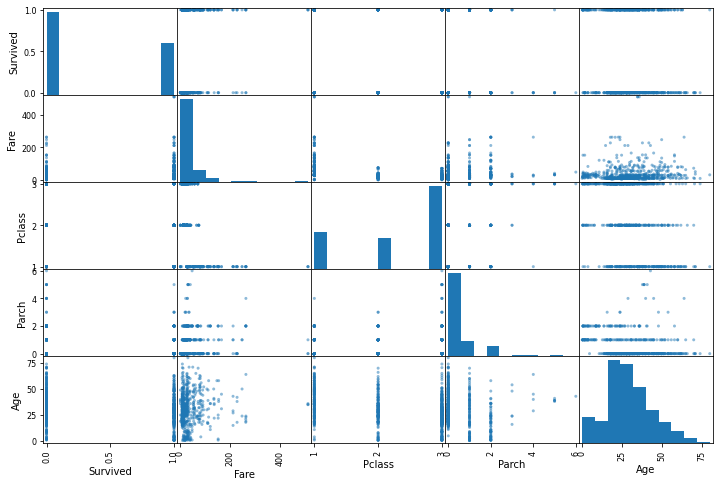

In [36]:
from pandas.plotting import scatter_matrix

# Top four correlated inputs with survived
attributes = ["Survived", "Fare", "Pclass", "Parch", "Age"]
scatter_matrix(data[attributes], figsize=(12, 8));

## Evaluate categorical features with respect to Survived

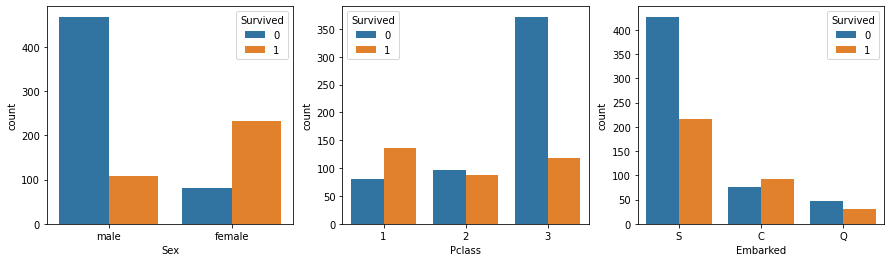

In [37]:
cat_vars = ['Sex', 'Pclass', 'Embarked']
plt.figure(figsize=(15,4))
for idx, cat in enumerate(cat_vars):
    plt.subplot(1, 3, idx+1)
    sns.countplot(data[cat], hue=data['Survived'])

# Build processing pipelines
In this part of the homework the focus is on constructing the pipeline. Since the data has both numerical and categorical features, it is required to create two pipelines (one for each category of data) because they require different transformations. After finishing that, the two pipelines should be unified to produce one full pipeline that performs transformation on all the dataset

In [38]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

# Identify the numeric features we wish to consider. 
num_attribs = [
    'Age', 
    'Parch', 
    'SibSp',
    'Fare'
]
# Create a pipeline for the numeric features.
# Use StandardScaler() to standardize the data
# Missing values will be imputed using the feature median.
#==================================================#
#               Your code starts here              #
#==================================================#
num_pipeline = Pipeline([('impute', SimpleImputer(strategy='median')),('std_scaler', StandardScaler())])
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#


# Identify the categorical features we wish to consider.
cat_attribs = [
    "Embarked", 
    "Sex",
    "Pclass"
]
# Identiy the range of expected values for the categorical features.
cat_values = [
    ['S','C','Q'],     # Embarked
    ['female','male'], # Sex
    [1,2,3] # Pclass
]
# Create a pipelne for the categorical features.
# Entries with missing values or values that don't exist in the range
# defined above will be one hot encoded as zeroes.
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

# Complete the code for the entire data pipeline 
# with numerical feature, categorical feature
#  Drop all remaining features
#==================================================#
#               Your code starts here              #
#==================================================#  

full_pipeline = ColumnTransformer(transformers=[
        ("num_pipeline", num_pipeline, num_attribs),
        ("cat_pipeline",cat_pipeline,cat_attribs)],
        remainder='drop',n_jobs=-1)

#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#



# Feature Engineering
When conducting an end to end Machine Learning project, after exploring and preprocessing the data it is essential to think of feature engineering. It consists of creating new feature(s) based on the features that already exist in the dataset that can be useful for training the model.

## Develop a new feature based on the title from each passengers name

### Evaluate the distribution of titles

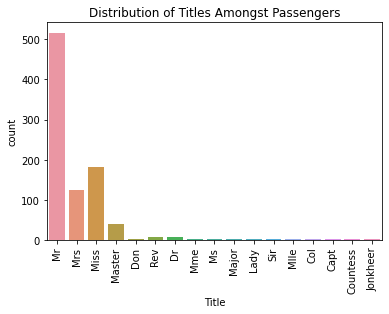

In [39]:
data['Title'] = data['Name'].apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=data)
plt.title('Distribution of Titles Amongst Passengers')
plt.xticks(rotation=90);

### Consolidate special and miscellaneous titles
Most titles fall into one of four categories (Mr, Mrs., Miss, Master).  All other titles can be combined with one of these groups (i.e., they are French varients) or grouped as "other". 

Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: Title, dtype: int64

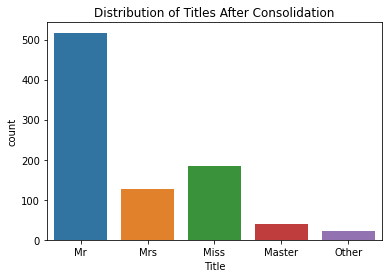

In [40]:
data['Title'] = data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
data['Title'] = data['Title'].replace(['Don', 'Dona', 'Rev', 'Dr','Major', 'Lady', 'Sir', 
                                       'Col', 'Capt', 'Countess', 'Jonkheer'],'Other')
sns.countplot(x='Title', data=data);
plt.title('Distribution of Titles After Consolidation')
data['Title'].value_counts()

## Create a transformer to perfom this new feature transformation in a pipeline

In [41]:
class TitleAdder(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        df = pd.DataFrame(X, columns=self.features)
        df['Title'] = df['Name'].apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
        # Apply the necessary transformations to obtain the 5 title categories
        # (Mr, Mrs, Miss, Master, Other) like it was done in section 5.1.2
        #==================================================#
        #               Your code starts here              #
        #==================================================#
        df['Title'] = df['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
        df['Title'] = df['Title'].replace(['Don', 'Dona', 'Rev', 'Dr','Major', 'Lady', 'Sir','Col', 'Capt', 'Countess', 'Jonkheer'],'Other')     
        #==================================================#
        #               Your code ends here                #
        #               Please don't add code below here   #
        #==================================================#
        df.drop('Name', axis=1, inplace=True)
        return np.array(df.values)

# Modeling
Now that we have explored the data, cleaned it, preprocessed it and added a new feature to it, we can start the modeling part of the project by applying Machine Learning algorithms. In this section, you will have a baseline logistic regression model and grid searches on different models. In the end, you will find out which parameters are the best for each algorithm and you will be able to compare the performance of the models with the baseline model.
## Baseline Logistic Regression

In [42]:
# use full pipeline above to build full pipeline with predictor
np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LogisticRegression(random_state=42))
    ])

# split data into train, test and validation set with random seed set to 42 for correct results
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=True,random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3, shuffle=True,random_state=42)

In [43]:
start = time()
full_pipeline_with_predictor.fit(x_train, y_train)
train_time = np.round(time() - start, 4)
np.random.seed(42)
logit_score_train = full_pipeline_with_predictor.score(x_train, y_train)

# Set up to calculate cross validation scores on validation data set
# Use ShuffleSplit() with 30 splits, 30% test_size 
# and a random seed of 0
#==================================================#
#               Your code starts here              #
#==================================================#
cv30Splits = ShuffleSplit(n_splits=30 , test_size=0.3,random_state=0)
logit_scores_valid = cross_val_score(full_pipeline_with_predictor,x_valid,y_valid,cv = cv30Splits)
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#

# cross fold validation validation accuracy with 30 splits
logit_score_valid = logit_scores_valid.mean()

# Time and score test predictions
start = time()
logit_score_test  = full_pipeline_with_predictor.score(x_test, y_test)
test_time = np.round(time() - start, 4)

In [44]:
results.loc[0] = ["Baseline", pct(logit_score_train), np.round(pct(logit_score_valid),3) ,np.round(pct(logit_score_test),3), 
                  "---", train_time, test_time, "Untuned LogisticRegression"]
results

,ExpID,Train accuracy,Cross fold validation Accuracy,Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,80.0,81.1,81.3,---,0.044,0.0114,Untuned LogisticRegression


## Decision Trees

Decision Tree is one of the popular and most widely used Machine Learning Algorithms because of its robustness to noise, tolerance against missing information, handling of irrelevant, redundant predictive attribute values, low computational cost, interpretability, fast run time and robust predictors. 

#### Cost functions used for classification and regression.
In both cases the cost functions try to find most homogeneous branches, or branches having groups with similar responses. 

Regression : sum(y — prediction)²

Classification : G = sum(pk * (1 — pk))

A Gini score gives an idea of how good a split is by how mixed the response classes are in the groups created by the split. Here, pk is proportion of same class inputs present in a particular group.

#### DecisionTreeClassifier

The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
Information gain uses the entropy measure as the impurity measure and splits a node such that it gives the most amount of information gain. Whereas Gini Impurity measures the divergences between the probability distributions of the target attribute’s values and splits a node such that it gives the least amount of impurity.

**Gini** :  $\Large 1 - \sum^m_{i=1}(P_j^2)$

**Entropy** : $\Large \sum^m_{i=1}\left(P_j\cdot\:\log\:\left(P_j\right)\:)\right)$

#### DecisionTreeRegressor

The decision of making strategic splits heavily affects a tree’s accuracy. The decision criteria is different for classification and regression trees.Decision trees regression normally use mean squared error (MSE) to decide to split a node in two or more sub-nodes. 

Suppose we are doing a binary tree the algorithm first will pick a value, and split the data into two subset. For each subset, it will calculate the MSE separately. The tree chooses the value with results in smallest MSE value.

${MSE}=\frac{1}{m} \sum_{i=1}^m  (x_{i}-y_{i})^2 $

#### Feature importance formula
To calculate the importance of each feature, we will mention the decision point itself and its child nodes as well. The following formula covers the calculation of feature importance. 

For each decision tree, Scikit-learn calculates a nodes importance using Gini Importance, assuming only two child nodes (binary tree):

$\Large ni_j = w_jC_j - w_{left(j)}C_{left(j)} - w_{right(j)}C_{right(j)}$  

**Where**

ni_j= the importance of node j

w_j = weighted number of samples reaching node j

C_j= the impurity value of node j

left(j) = child node from left split on node j

right(j) = child node from right split on node j

The importance for each feature on a decision tree is then calculated as:

$\Large fi_i = \frac{\sum_{j:node \hspace{0.1cm} j \hspace{0.1cm} splits \hspace{0.1cm} on \hspace{0.1cm} feature \hspace{0.1cm} i}ni_j}{\sum_{k \hspace{0.1cm} \epsilon \hspace{0.1cm} all \hspace{0.1cm} nodes }ni_k}$

These can then be normalized to a value between 0 and 1 by dividing by the sum of all feature importance values:

$\Large normfi_i = \frac{fi_i}{\sum_{j \hspace{0.1cm}  \epsilon \hspace{0.1cm} all \hspace{0.1cm} features}fi_j}$

#### Decision Trees Parameters for classification

**criterion{“gini”, “entropy”}, default=”gini”** :The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

**max_depth, default=None** : The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_leaf int or float, default=1** : The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

#### Decision Trees Parameters for Regression

**criterion{“mse”, “friedman_mse”, “mae”, “poisson”}, default=”mse”** : The function to measure the quality of a split. 

**max_depth, default=None** : The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_leaf int or float, default=1** : The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

#### Random Forest Parameters

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

**n_estimatorsint, default=100** : The number of trees in the forest.

**max_depthint, default=None** : The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**max_features** : The number of features to consider when looking for the best split.

**min_impurity_decreasefloat, default=0.0** : Threshold for early stopping in tree growth. A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

**bootstrapbool, default=True** : Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

### Regression Code

#### Decision Tree

In [45]:
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

boston = load_boston()
data=pd.DataFrame(boston.data)
data.columns = boston.feature_names
data['PRICE']=boston.target
X_boston,y_boston = data.iloc[:,:-1],data.iloc[:,-1]

In [46]:
from sklearn.model_selection import train_test_split

X_train_boston, X_test_boston, y_train_boston, y_test_boston = train_test_split(X_boston, y_boston, test_size=0.15, shuffle=True,random_state=42)
X_train_boston, X_valid_boston, y_train_boston, y_valid_boston = train_test_split(X_train_boston, y_train_boston, test_size=0.3, shuffle=True,random_state=42)

# Initialize and fit regressor

tree = DecisionTreeRegressor(criterion='mse',max_depth=4,random_state = 42)
tree.fit(X_train_boston, y_train_boston)

y_preds_boston = tree.predict(X_test_boston)

rmse = np.sqrt(mean_squared_error(y_test_boston,y_preds_boston))
print ('RMSE=%f'% (rmse))

RMSE=3.834096


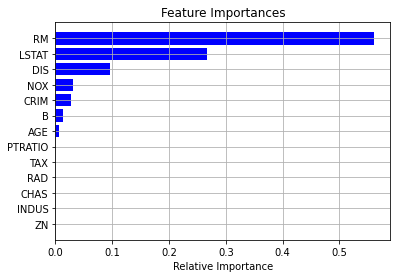

In [47]:
features = X_train_boston.columns
importances = tree.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.show();

#### Random forest

In [48]:
RF = RandomForestRegressor(random_state = 42,n_estimators=100,criterion='mse',max_depth=6)

RF.fit(X_train_boston, y_train_boston)

y_preds_boston = RF.predict(X_test_boston)

rmse = np.sqrt(mean_squared_error(y_test_boston,y_preds_boston))
print ('RMSE=%f'% (rmse))

RMSE=2.493191


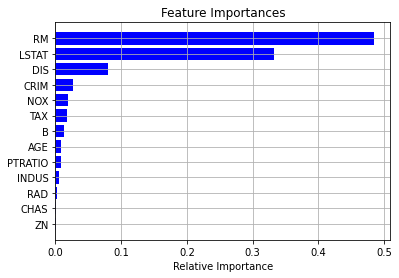

In [49]:
features = X_train_boston.columns
importances = RF.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()

plt.show();

### Classification Code

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, x_valid, y_valid ,X_test, y_test, i=0, prefix='', n_jobs=-1,verbose=1):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('DecisionTrees', DecisionTreeClassifier(random_state=42)),
        ('RandomForest', RandomForestClassifier(random_state=42))
        
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'DecisionTrees' : {
            'criterion':['gini','entropy'],
            'max_depth':range(1,10),
            
            'min_samples_leaf':range(1,5)
        },
        
       'RandomForest':  {
            'max_depth': [9, 15, 22,],
            'max_features': [1, 3, 5],
            'min_samples_leaf': [3, 5, 10],
            'min_impurity_decrease':[0,1e-3,1e-4,1e-6],
            'bootstrap': [True],
            'n_estimators':[ 100, 150, 200]}
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=5, 
                                   n_jobs=n_jobs, verbose=verbose)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        best_train_accuracy = pct(grid_search.best_estimator_.score(X_train, y_train))
        train_time = round(time() - start, 4)
        
#         plt.barh(['Age', 'Parch', 'SibSp','Fare','x0_C' ,'x0_Q' ,'x0_S' ,'x1_female', 'x1_male' ,'x2_1' ,'x2_2', 'x2_3'], grid_search.best_estimator_.named_steps["predictor"].feature_importances_)
#         plt.show()
        features = ['Age', 'Parch', 'SibSp','Fare','x0_C' ,'x0_Q' ,'x0_S' ,'x1_female', 'x1_male' ,'x2_1' ,'x2_2', 'x2_3']
        importances = grid_search.best_estimator_.named_steps["predictor"].feature_importances_
        indices = np.argsort(importances)

        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.grid()
        plt.show();
        
        # Best estimator prediction time
        start = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        test_time = round(time() - start, 4)

        # Generate 30 validation accuracy scores with the best estimator and 30-split CV
        # Use ShuffleSplit() with 30 splits, 30% test_size and a random seed of 0
        # To calculate the best_validation_accuracy 
        # use the pct() and mean() methods
        #==================================================#
        #               Your code starts here              #
        #==================================================#
        cv30Splits = ShuffleSplit(n_splits=30 , test_size=0.3,random_state=0)
        best_validation_scores = cross_val_score(grid_search.best_estimator_, x_valid,y_valid, cv = cv30Splits)
        best_validation_accuracy = pct(best_validation_scores.mean())
        
        #==================================================#
        #               Your code ends here                #
        #               Please don't add code below here   #
        #==================================================#    
       
        
        
        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores_valid, best_validation_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_validation_accuracy ,best_test_accuracy, round(p_value,5), train_time, test_time, json.dumps(param_dump)]
        
        

****** START Best Model: DecisionTrees *****
Parameters:
	criterion: ['gini', 'entropy']
	max_depth: range(1, 10)
	min_samples_leaf: range(1, 5)
Fitting 5 folds for each of 72 candidates, totalling 360 fits


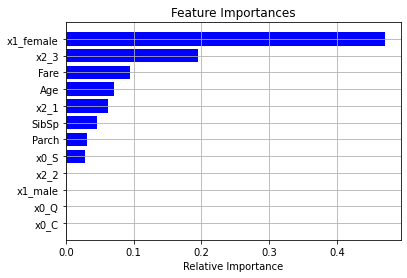

Best Parameters:
	predictor__criterion: entropy
	predictor__max_depth: 4
	predictor__min_samples_leaf: 1
****** FINISH Best Model: DecisionTrees  *****

****** START Best Model: RandomForest *****
Parameters:
	bootstrap: [True]
	max_depth: [9, 15, 22]
	max_features: [1, 3, 5]
	min_impurity_decrease: [0, 0.001, 0.0001, 1e-06]
	min_samples_leaf: [3, 5, 10]
	n_estimators: [100, 150, 200]
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


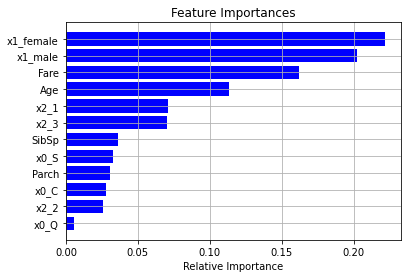

Best Parameters:
	predictor__bootstrap: True
	predictor__max_depth: 9
	predictor__max_features: 1
	predictor__min_impurity_decrease: 0
	predictor__min_samples_leaf: 5
	predictor__n_estimators: 150
****** FINISH Best Model: RandomForest  *****



In [51]:
ConductGridSearch(x_train, y_train, x_valid, y_valid, x_test, y_test, 0, "Best Model:",  n_jobs=-1,verbose=1)

In [52]:
results

,ExpID,Train accuracy,Cross fold validation Accuracy,Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,80.0,81.1,81.3,---,0.0440,0.0114,Untuned LogisticRegression
1,Best Model:DecisionTrees,83.6,80.9,82.1,0.77265,0.0252,0.0106,"[[""predictor__criterion"", ""entropy""], [""predic..."
2,Best Model:RandomForest,82.8,81.6,82.1,0.48213,0.2721,0.0390,"[[""predictor__bootstrap"", true], [""predictor__..."


## Conduct Grid Search using a variety of Classification Algorithms

In this section, we're going to try to answer the following questions
Note: These questions should be answered in Canvas once you have completed this section.
### Best validation accuracy
    Please submit the code snippet you added to calculate the best validation accuracy in the section below of the notebook
### Best parameters for Logistic Regression 
    Based on the results obtained after conducting Grid Search in this section , choose the best parameters for Logistic Regression
### Best parameters for k-nearest neighbors
    Based on the results obtained after conducting Grid Search in this section, what is  the best parameter for n_neighbors for k-nearest neighbors?
### SVM Test Accuracy
Please enter the calculated value for test Accuracy of Support vector model in the section below of the notebook. 
(Report your number to 1 decimal point of precision. For example: 2.5)
### Statistical significance
    Which one of the models listed below is the most statistically significant based on the results of this section? 
    * Naive Bayes
    * Stochastic GD
    * RandomForest
    * Logistic Regression
### Choosing the best model
    Given the results that you obtained for the different models in this section, based on what information would you choose the best model to deploy? 
    * Cross fold Train Accuracy
    * Test Accuracy
    * p-value
    * Train Time
    * Test Time
 
    

In [ ]:

# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, x_valid, y_valid, X_test, y_test, i=0, prefix='', n_jobs=-1,verbose=1):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=42)),
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('Support Vector', SVC(random_state=42)),
        ('Stochastic GD', SGDClassifier(random_state=42)),
        ('RandomForest', RandomForestClassifier(random_state=42))
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Logistic Regression': {
            'penalty': ('l1', 'l2'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'C': (10, 1, 0.1, 0.01),
        },
        'K-Nearest Neighbors': {
            'n_neighbors': (3, 5, 7, 8, 11),
            'p': (1,2),
        },
        'Naive Bayes': {},
        'Support Vector' : {
            'kernel': ('rbf', 'poly'),     
            'degree': (1, 2, 3, 4, 5),
            'C': (10, 1, 0.1, 0.01),
        },
        'Stochastic GD': {
            'loss': ('hinge', 'perceptron', 'log'),
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'alpha': (0.1, 0.01, 0.001, 0.0001), 
        },
        'RandomForest':  {
            'max_depth': [9, 15, 22, 26, 30],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [3, 5, 10],
            'bootstrap': [False],
            'n_estimators':[20, 80, 150, 200, 300]},
 
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=5, 
                                   n_jobs=n_jobs, verbose=verbose)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        best_train_accuracy = pct(grid_search.best_estimator_.score(X_train, y_train))
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        test_time = round(time() - start, 4)

        # Generate 30 validation accuracy scores with the best estimator and 30-split CV
        # Use ShuffleSplit() with 30 splits, 30% test_size and a random seed of 0
        # To calculate the best_validation_accuracy, use the pct() and mean() methods
        #==================================================#
        #               Your code starts here              #
        #==================================================#
        cv30Splits = ShuffleSplit(n_splits=30 , test_size=0.3,random_state=0)        
        best_validation_scores = cross_val_score(grid_search.best_estimator_, x_valid,y_valid, cv = cv30Splits)
        best_validation_accuracy = pct()
        #==================================================#
        #               Your code ends here                #
        #               Please don't add code below here   #
        #==================================================#    
       
        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores_valid, best_validation_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_validation_accuracy ,best_test_accuracy, round(p_value,5), train_time, test_time, json.dumps(param_dump)]

In [ ]:
%%time
# This might take a while
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    # n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
    #
    # By default, the GridSearchCV uses a 3-fold cross-validation. However, if it 
    #            detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.
    ConductGridSearch(x_train, y_train, x_valid, y_valid, x_test, y_test, 0, "Best Model:",  n_jobs=-1,verbose=1)

****** START Best Model: Logistic Regression *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	penalty: ('l1', 'l2')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters:
	predictor__C: 0.1
	predictor__penalty: l2
	predictor__tol: 0.0001
****** FINISH Best Model: Logistic Regression  *****

****** START Best Model: K-Nearest Neighbors *****
Parameters:
	n_neighbors: (3, 5, 7, 8, 11)
	p: (1, 2)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:
	predictor__n_neighbors: 7
	predictor__p: 1
****** FINISH Best Model: K-Nearest Neighbors  *****

****** START Best Model: Naive Bayes *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters:
****** FINISH Best Model: Naive Bayes  *****

****** START Best Model: Support Vector *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	degree: (1, 2, 3, 4, 5)
	kernel: ('rbf', 'poly')
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parame

In [ ]:
results

,ExpID,Train accuracy,Cross fold validation Accuracy,Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,80.0,81.1,81.3,---,0.0440,0.0114,Untuned LogisticRegression
1,Best Model:Logistic Regression,80.7,80.2,80.6,0.05458,0.0358,0.0091,"[[""predictor__C"", 0.1], [""predictor__penalty"",..."
2,Best Model:K-Nearest Neighbors,82.6,82.0,82.8,0.18011,0.0574,0.0192,"[[""predictor__n_neighbors"", 7], [""predictor__p..."
3,Best Model:Naive Bayes,77.3,81.2,76.9,0.92757,0.0242,0.0096,[]
4,Best Model:Support Vector,83.6,83.6,80.6,0.00009,0.0487,0.0122,"[[""predictor__C"", 1], [""predictor__degree"", 3]..."
5,Best Model:Stochastic GD,80.5,81.6,80.6,0.11526,0.0276,0.0095,"[[""predictor__alpha"", 0.01], [""predictor__loss..."
6,Best Model:RandomForest,90.9,80.9,85.1,0.7301,0.3629,0.0446,"[[""predictor__bootstrap"", false], [""predictor_..."


## Observations

* The Support Vector Classifier with parameters [C=1, degree=3, kernel=poly] had the best overall performance. The p-values of 0.00009 indicate that the results are signficantly different from the baseline Logistic Regression model. 
* There tuned Logistic Regression was not statistically different than the baseline (untuned) model.

# OPTIONAL: TMDB Box Office Prediction on Kaggle

 For this part of the homework 
You will need to look at the  [TMDB Box Office Prediction Competition on Kaggle](https://www.kaggle.com/c/tmdb-box-office-prediction)
Through the lectures and lab we learned how to predict house prices in California. In this homework, we adopted  the end to end pipeline to tackle the Titanic Survival problem. Now, we want you to adopt the machine learning pipeline to tackle the TMDB Box Office Prediction

In this dataset, you are provided with 7,398  movies (3,000 for training and 4,398 for testing) and a variety of metadata obtained from The Movie Database (TMDB). Movies are labeled with id. Data points include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries.

Feel free to use the [Kaggle API](https://github.com/Kaggle/kaggle-api) for downloading the dataset or submitting to the competition. It is not mandatory to use the package but it would be interesting to explore.
   You will need to: 
* __Important:__ Make sure your results are reproducible 
* __Important:__ Use the training data set provided by the competition to create a training set(70%), validation set (15%) and a test set (15%)
* __EDA.__ Identify the types of data available, evaluate basic statistical information about the data and determine whether you have any missing or misformated data.

* __Feature Engineering.__  Develop at least one new feature based on the existing features of the dataset
* __Pre-processing.__  All work must be performed using pipelines.  You can adapt code from above or develop your own.
* __Modeling.__Evaluate at least two appropriate algorithms (estimators) for generating predictions.
    * Use grid search to tune hyperparameters.
    * Use crossfold evaluation (cv=5).
* __Evaluation.__ Select appropriate metrics for the problem to evaluate your models.
* __Reporting.__ Record all experiments in a table of results (pandas dataframe) including at least the following information:  
    * description of the model (algorithim, notable processing steps) 
    * key hyperparameters
    * results (using one or more appropriate metrics)
    * run time for each experiment (train and test results)
    * hardware used
* __Analysis__. Perform a significance test on your best models and discuss results (see Module 09.5 in Canvas for a video lecture on significance testing).
* __Submit your best model to Kaggle__ Provide a screenshot of the kaggle submission
* __Comment your code and provide explanations of how you're proceeding in each part__


## Data Import & notebook preperation


In [ ]:
import pandas as pd


In [ ]:
data = pd.read_csv('datasets/TMDB/train.csv')
y = data ['revenue']
x = data .drop(['revenue'], axis = 1)
test_data = pd.read_csv('datasets/TMDB/test.csv')


* __Important:__ Remember that x and y should be split into a training set (70% of the original dataset), a validation set (15% of the original dataset) and a test set (15% of the original dataset. 
* test_data will be only used for the kaggle submission

## EDA

## Feature engineering

## Preprocessing


## Modeling

## Evaluation, reporting and analysis


## Kaggle Submission


# Monitoring Training Performance With XGBoost
**Important: If you are using Docker course container for ARM architecture, please run the section 8 code on Google colab to get the same result as the x86 Docker course container**

The XGBoost model can evaluate and report on the performance on a test set for the the model during training.

It supports this capability by specifying both an test dataset and an evaluation metric on the call to model.fit() when training the model and specifying verbose output.

For example, we can report on the binary classification error rate (“error“) on a standalone test set (eval_set) while training an XGBoost model as follows:

```python
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)

```
XGBoost supports a suite of evaluation metrics not limited to:

* “rmse” for root mean squared error.
* “mae” for mean absolute error.
* “logloss” for binary logarithmic loss and “mlogloss” for multi-class log loss (cross entropy).
* “error” for classification error.
* “auc” for area under ROC curve.

The full list is provided in the [Learning Task Parameters](http://xgboost.readthedocs.io/en/latest//parameter.html) section of the XGBoost Parameters webpage.

This section is based on [this webpage](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/).

For example, we can demonstrate how to track the performance of the training of an XGBoost model on the Pima Indians onset of diabetes dataset, available from the UCI Machine Learning Repository.

The full example is provided below:



In [ ]:
!pwd

/N/home/u010/amandyar/Carbonate/Desktop/AML/I526_AML_Student/Assignments/Unit-13-Pipelines-and-end-to-end-ML-Project


In [59]:
# plot learning curve
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
# load data
dataset = loadtxt('datasets/pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=7)
# fit model 
# use 100 trees but use early stopping to build a smaller ensemble and thereby prevent overfitting 
model = XGBClassifier(n_estimators=100)
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("TEST Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.14169	validation_0-logloss:0.55659	validation_1-error:0.26623	validation_1-logloss:0.59868
[1]	validation_0-error:0.12704	validation_0-logloss:0.47523	validation_1-error:0.20779	validation_1-logloss:0.53884
[2]	validation_0-error:0.11075	validation_0-logloss:0.41111	validation_1-error:0.25325	validation_1-logloss:0.51511
[3]	validation_0-error:0.09935	validation_0-logloss:0.36541	validation_1-error:0.25325	validation_1-logloss:0.49522
[4]	validation_0-error:0.09772	validation_0-logloss:0.33817	validation_1-error:0.25325	validation_1-logloss:0.49203
[5]	validation_0-error:0.08958	validation_0-logloss:0.31491	validation_1-error:0.24675	validation_1-logloss:0.48838
[6]	validation_0-error:0.09120	validation_0-logloss:0.29348	validation_1-error:0.24675	validation_1-logloss:0.48265
[7]	validation_0-error:0.08795	validation_0-logloss:0.27777	validation_1-error:0.22727	validation_1-logloss:0.48166
[8]	validation_0-error:0.06515	validation_0-logloss:0.25941	validation_1

## Evaluate XGBoost Models With Learning Curves
We can retrieve the performance of the model on the evaluation dataset and plot it to get insight into how learning unfolded while training.

We provide an array of X and y pairs to the eval_metric argument when fitting our XGBoost model. In addition to a test set, we can also provide the training dataset. This will provide a report on how well the model is performing on both training and test sets during training.



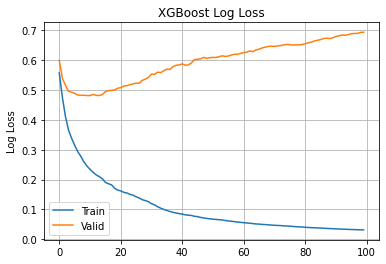

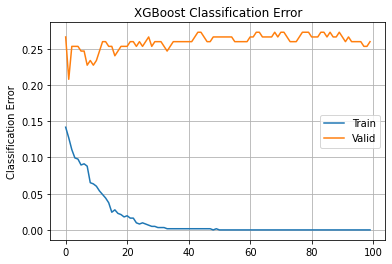

In [60]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Valid')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.grid()
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Valid')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.grid()
pyplot.show()

### Discussion
Running this code reports the classification error on both the train and test datasets each epoch. We can turn this off by setting verbose=False (the default) in the call to the fit() function.

Two plots were created. The first shows the logarithmic loss of the XGBoost model for each epoch on the training and test datasets.

From reviewing the logloss plot, it looks like there is an opportunity to stop the learning early, perhaps somewhere around epoch 45 to epoch 60.

We see a similar story for classification error, where error appears to go back up at around epoch 60.

## Early Stopping With XGBoost: early_stopping_rounds=10
XGBoost supports early stopping after a fixed number of iterations.

In addition to specifying a metric and test dataset for evaluation each epoch, you must specify a window of the number of epochs over which no improvement is observed. This is specified in the early_stopping_rounds parameter.

For example, we can check for no improvement in logarithmic loss over the 10 epochs as follows:

```python
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
```
If multiple evaluation datasets or multiple evaluation metrics are provided, then early stopping will use the last in the list.

Below provides a full example for completeness with early stopping.

In [62]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
# load data
dataset = loadtxt('datasets/pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=7)
# fit model 
# use 100 trees but use early stopping to build a smaller ensemble and thereby prevent overfitting 
model = XGBClassifier(n_estimators=100)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-logloss:0.59868
[1]	validation_0-logloss:0.53884
[2]	validation_0-logloss:0.51511
[3]	validation_0-logloss:0.49522
[4]	validation_0-logloss:0.49203
[5]	validation_0-logloss:0.48838
[6]	validation_0-logloss:0.48265
[7]	validation_0-logloss:0.48166
[8]	validation_0-logloss:0.48194
[9]	validation_0-logloss:0.48107
[10]	validation_0-logloss:0.48081
[11]	validation_0-logloss:0.48464
[12]	validation_0-logloss:0.48164
[13]	validation_0-logloss:0.48102
[14]	validation_0-logloss:0.48444
[15]	validation_0-logloss:0.49379
[16]	validation_0-logloss:0.49739
[17]	validation_0-logloss:0.49816
[18]	validation_0-logloss:0.49997
[19]	validation_0-logloss:0.50532
Accuracy: 76.62%


Running the example provides the following output, truncated for brevity:

```
[48]	validation_0-logloss:0.463471
[49]	validation_0-logloss:0.463432
[50]	validation_0-logloss:0.462447
[51]	validation_0-logloss:0.461978
[52]	validation_0-logloss:0.461132
[53]	validation_0-logloss:0.461343
[54]	validation_0-logloss:0.462114
[55]	validation_0-logloss:0.462166
[56]	validation_0-logloss:0.462295
[57]	validation_0-logloss:0.462918
[58]	validation_0-logloss:0.462871
[59]	validation_0-logloss:0.462235
[60]	validation_0-logloss:0.46168
[61]	validation_0-logloss:0.462099
[62]	validation_0-logloss:0.462628
Stopping. Best iteration:
[52]	validation_0-logloss:0.461132

Accuracy: 81.82%
```

### Discussion: early_stopping_rounds is set to 10% of training budget
We can see that the model stopped training at epoch 52 (close to what we expected by our manual judgment of learning curves) and that the model with the best loss was observed at epoch 52.

It is generally a good idea to select the early_stopping_rounds as a reasonable function of the total number of training epochs (10% in this case) or attempt to correspond to the period of inflection points as might be observed on plots of learning curves. Here, `early_stopping_rounds=10`.



## TASK:
Adopt the code given in the section 8.2 and set the early stoping round to 1. Report the test accuracy   

Based on your observation on using different values for early stopping round, discuss why early stoping round set equals to 1 is not a good policy?